I came across a wonderful ML blog written by Jason Brownlee and decide to replicate one of his amazing work for fun.
https://machinelearningmastery.com/

## Dataset

The dataset used is the "Glass dataset" from Vina Spiehler in 1987.
It's available everywhere but I chose to download it from Kaggle since it is already in csv format.
from Kaggle: https://www.kaggle.com/uciml/glass
from UCI: https://archive.ics.uci.edu/ml/datasets/glass+identification

The dataset consists of total 11 variables; one variable for the label and the other ten for attributes and the ID

In [1]:
# id: Id number: 1 to 214 (removed)
# RI: refractive index
# Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
# Mg: Magnesium
# Al: Aluminum
# Si: Silicon
# K: Potassium
# Ca: Calcium
# Ba: Barium
# Fe: Iron
# Type of glass: (class attribute)

## Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier

import seaborn as sns

# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessClassifier

### Load data

In [3]:
def get_data(path):
    return pd.read_csv(path)

In [4]:
data_dir = 'glass.csv'
df_glass = get_data(data_dir)

Here is our 'Glass' data. It consists of 214 observations and has 10 variables.

In [5]:
df_glass

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


The mean of variable 'Type' (2.78) implies that our dataset has imbalanced classes and the majority classes should be Typr 1 and 2.
The mean should be around 4 if the dataset has a balanced class distribution.

In [6]:
df_glass.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


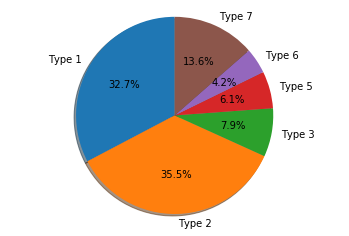

In [7]:
classes, counts = np.unique(df_glass['Type'], return_counts=True)
classes = ['Type '+str(i) for i in classes]
fig, ax = plt.subplots()
ax.pie(counts, labels=classes, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')
plt.show()

As expected, glass type 1 and 2 are the majority classes in the dataset (67% of total data) while the other classes are the monirity and type 4 doesn't exist.

### Missing data and data types

In [8]:
# types of data in each column
df_glass.dtypes

RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object

In [9]:
# checking for missing data
df_glass.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

### A quick look at our dataset

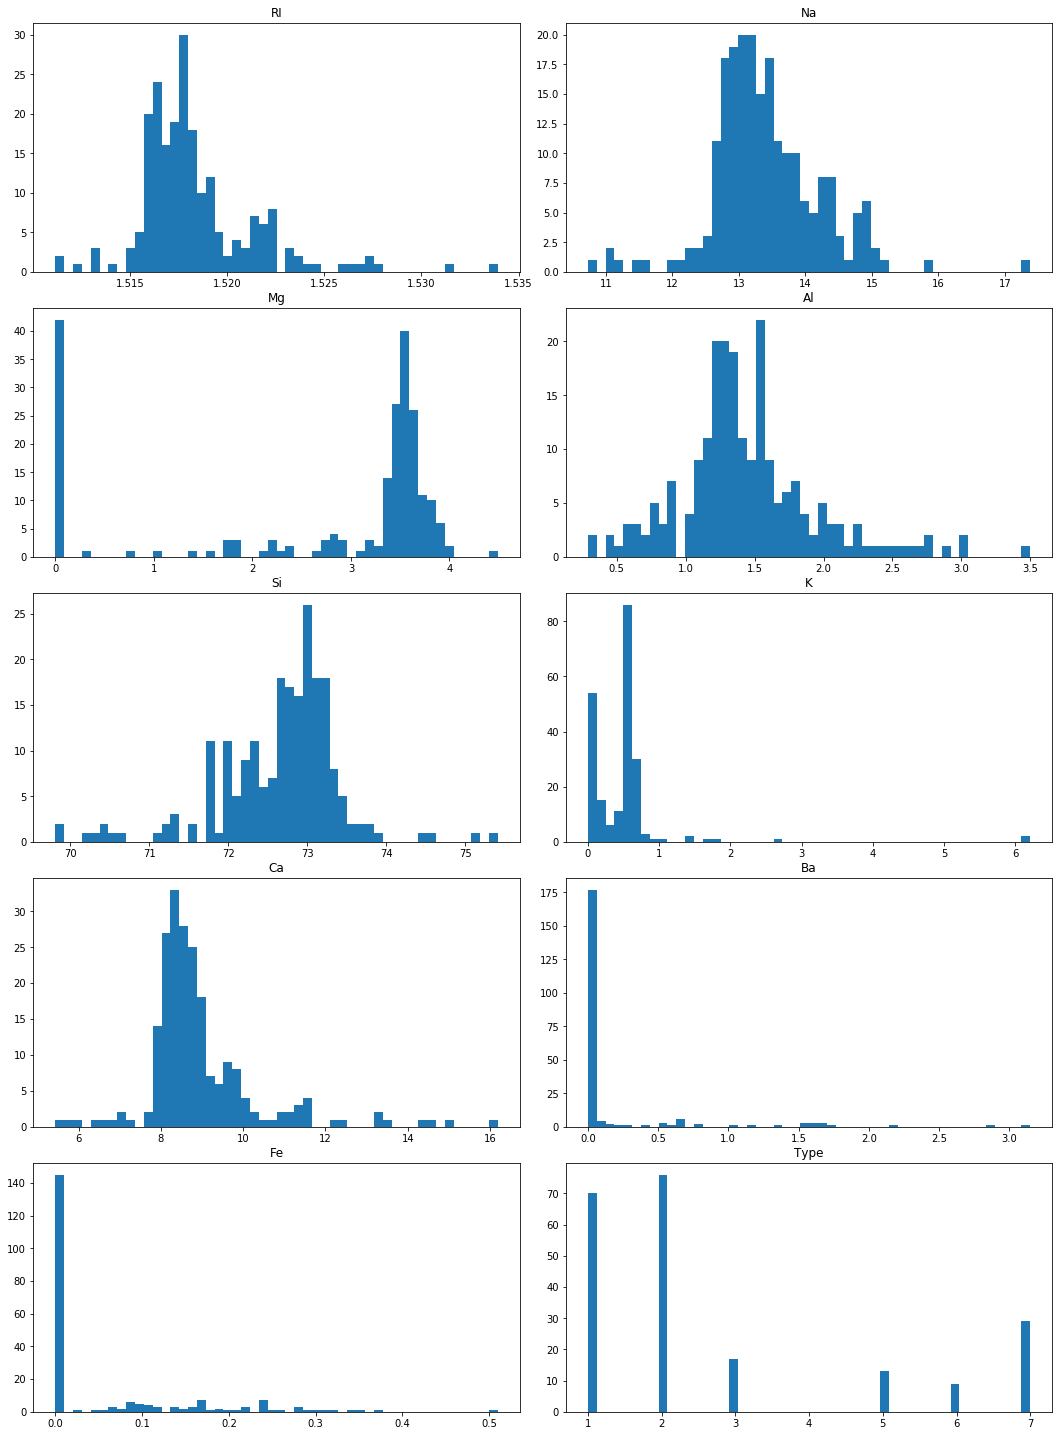

In [10]:
# Observing distribution
plt_row, plt_col = 5, 2
fig, axs = plt.subplots(plt_row, plt_col, figsize=(15,20))
fig.tight_layout(pad=1.5)
for e, col in enumerate(df_glass.columns):
    axs[e//plt_col, e%plt_col].hist(df_glass[col], bins=50)
    axs[e//plt_col, e%plt_col].set_title(col)
    #axs[e//plt_col, e%plt_col].yaxis.grid()

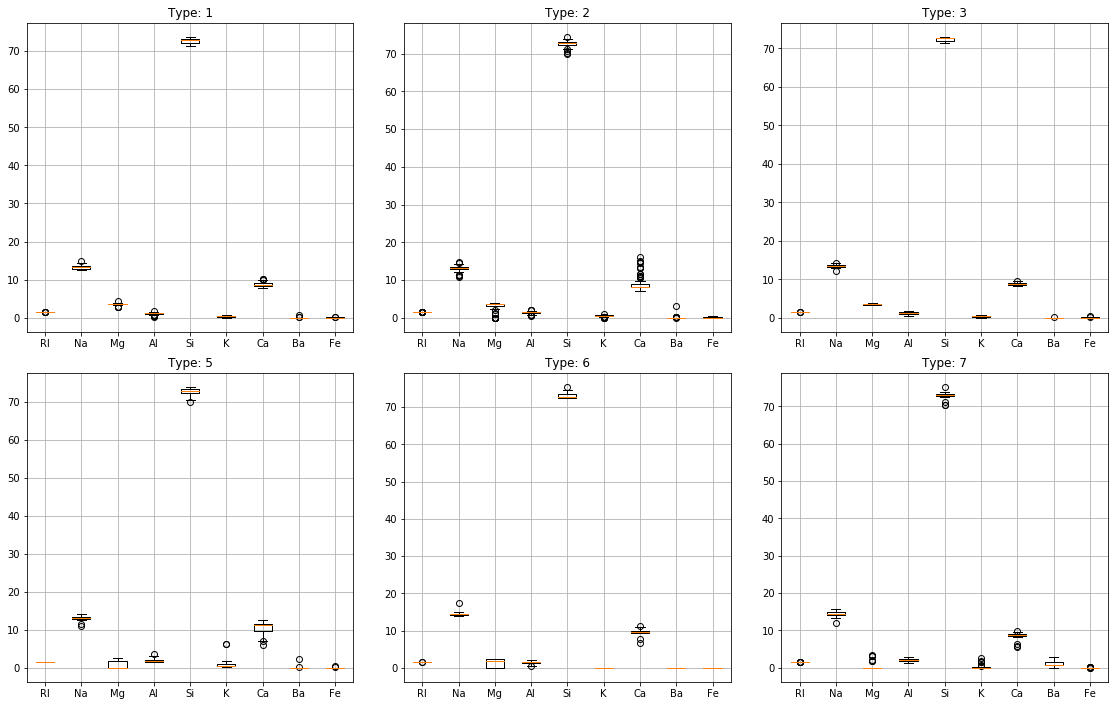

In [11]:
# Each type of glass
plt_row, plt_col = 2, 3
fig, axs = plt.subplots(plt_row, plt_col, figsize=(16,10))
fig.tight_layout(pad=2)
for e, types in enumerate(df_glass.Type.unique()):
    axs[e//plt_col, e%plt_col].boxplot([df_glass[df_glass['Type']==types][df_glass.columns[:-1]][col] for col in df_glass[df_glass['Type']==types][df_glass.columns[:-1]]])
    axs[e//plt_col, e%plt_col].set_title('Type: ' +str(types))
    axs[e//plt_col, e%plt_col].set_xticklabels(df_glass.columns[:-1])
    axs[e//plt_col, e%plt_col].grid()

Visualization is a great tool that summarizes the characteristics of data and present them in an easy-to-understand format. However, there're times when visualization is not the best solution and quantitative methods are usually preferable. From the boxplots above, it is difficult to see the difference of elements in each type of glass because they have very similar patterns.

In a case like this, a correlation matrix comes in handy.

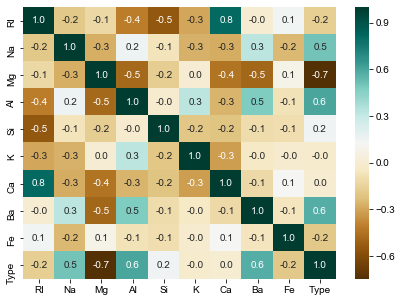

In [12]:
# checking correlations
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(df_glass.corr(),
            annot=True,
            fmt= '.1f',
            ax=ax,
            cmap='BrBG')
sns.set(font_scale=1)
plt.show()

'Mg' ( Magnisium ) , 'Al' ( Aluminium ) , and 'Ba' ( Barium )  are highly correlated with the 'type of glass'.

## Data Preprocessing

In [13]:
def normal(dat):
    return (dat-dat.min())/(dat.max()-dat.min())

def standard(dat):
    return (dat-dat.mean())/dat.std()

In [14]:
df_normal = normal(df_glass)
df_standard = standard(df_glass)

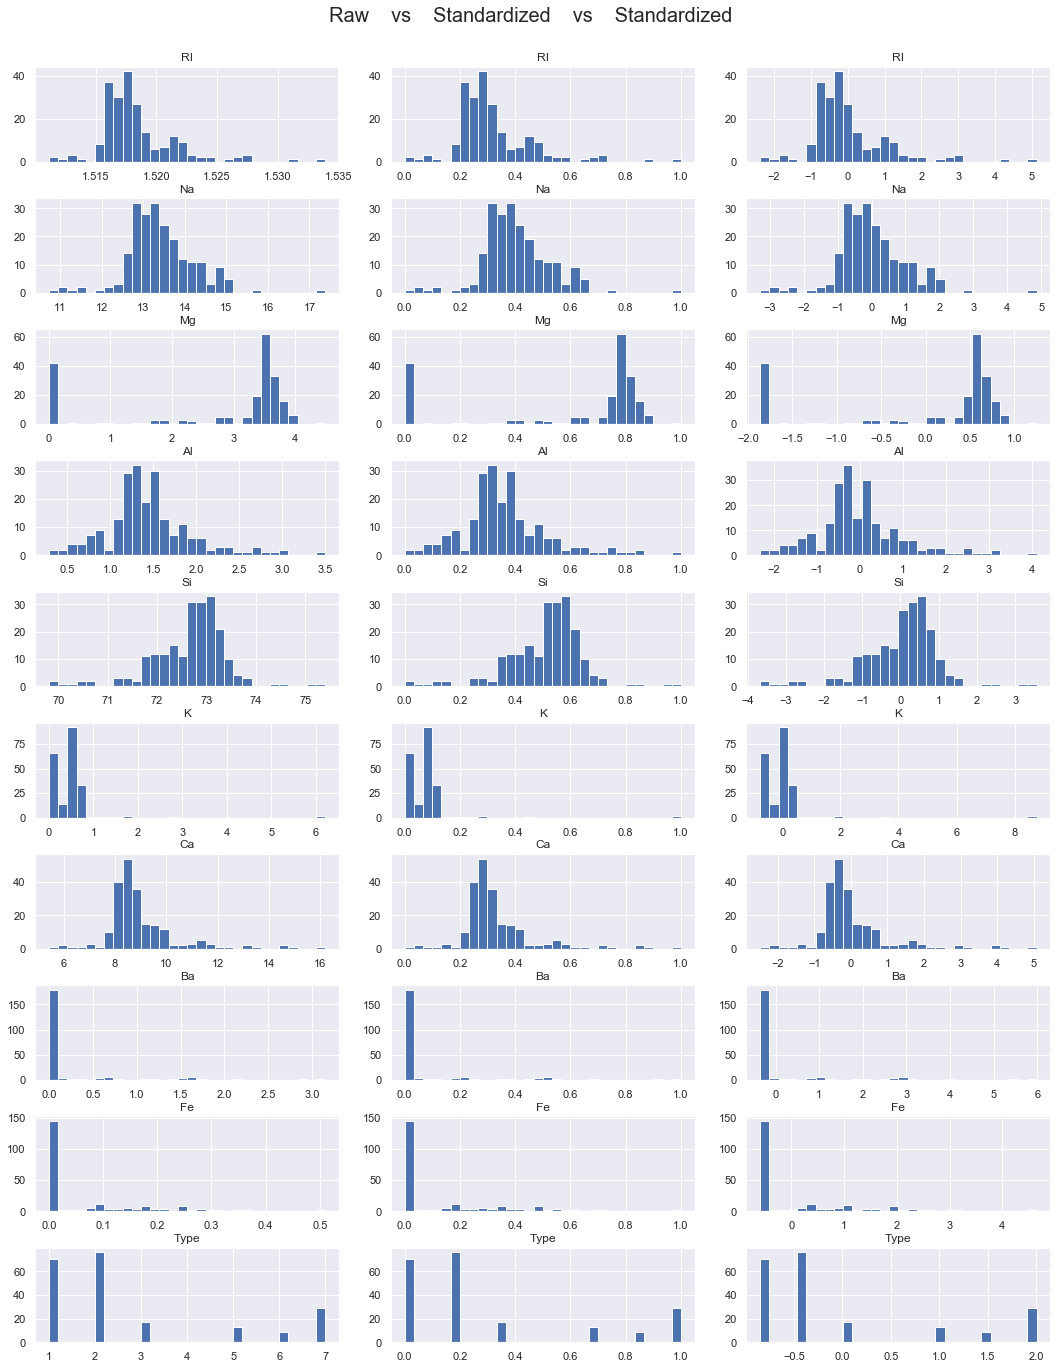

In [15]:
plt_row, plt_col = 10, 3
fig, axs = plt.subplots(plt_row, plt_col, figsize=(15,20))
fig.tight_layout(pad=1.5)
title = 'Raw    vs    Standardized    vs    Standardized'
fig.suptitle(title, fontsize=20, va='top')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
for col, col_normal, col_standard, e in zip(df_glass, df_normal, df_standard, np.arange(0,10,1)):
    axs[e, 0].hist(df_glass[col], bins=30)
    axs[e, 0].set_title(col)
    axs[e, 1].hist(df_normal[col_normal], bins=30)
    axs[e, 1].set_title(col_normal)
    axs[e, 2].hist(df_standard[col_standard], bins=30)
    axs[e, 2].set_title(col_standard)

## Modeling and Evaluation

In [16]:
"""This function separate 'Type of glass' from all the other variables"""
def make_XY(dat):
    """Gives X, Y respectively"""
    return dat[dat.columns[:-1]], dat[dat.columns[-1]]

In [17]:
def evaluate(dat, model, K=5):
    X, y = dat
    """Repeated Stratified K-fold makes sure each fold has similar data distribution"""
    # n_splits*n_repeat = number of times to be evaluated
    RSCV = RepeatedStratifiedKFold(n_splits=K, n_repeats=3, random_state=1)
    # n_jobs = 1 using one CPU, or -1 = using all CPUs
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=RSCV, n_jobs=-1)
    return scores

In [18]:
make_XY(get_data(data_dir))[0].shape, make_XY(get_data(data_dir))[1].shape

((214, 9), (214,))

### Baseline

In [19]:
# We will use DummyClassifier from sklean to obtain our baseline score.
# The function predicts the most frequent class.
data_dir = 'glass.csv'
# model that predicts only the most frequent class
model = DummyClassifier(strategy='most_frequent')
scores = evaluate(make_XY(get_data(data_dir)), model)

In [20]:
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.355 (0.009)


### Candidate models

In [21]:
def get_candidate_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='lbfgs', multi_class='multinomial'))
    names.append('LR ')
    # SVM
    models.append(SVC(gamma='auto'))
    names.append('SVM')
    # KNN
    models.append(KNeighborsClassifier())
    names.append('KNN')
    # Bagging
    models.append(BaggingClassifier(n_estimators=128))
    names.append('BAG ')
    # RF
    models.append(RandomForestClassifier(n_estimators=128, max_depth=8, random_state=123))
    names.append('RF ')
    # ET
    models.append(ExtraTreesClassifier(n_estimators=128, random_state=123))
    names.append('ET ')
    # XGBClassifier
    models.append(XGBClassifier(n_estimators=128, max_depth=8, random_state=123))
    names.append('XGB')
    return models, names

In [22]:
# define models
models, names = get_candidate_models()
results = list()

# evaluate each model
for i in range(len(models)):
    # evaluate the model and store results
    X, y = make_XY(get_data(data_dir))
    scores = evaluate((standard(X), y), models[i])
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LR  0.638 (0.060)
>SVM 0.715 (0.041)
>KNN 0.661 (0.052)
>BAG  0.774 (0.058)
>RF  0.793 (0.052)
>ET  0.782 (0.047)
>XGB 0.787 (0.029)


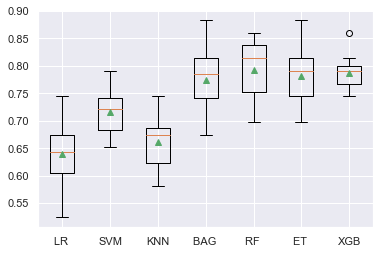

In [23]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### Prediction from the best model

In [24]:
X, y = make_XY(get_data(data_dir))
X = standard(X)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True)

In [25]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(149, 9) (65, 9)
(149,) (65,)


In [26]:
model = RandomForestClassifier(n_estimators=128, max_depth=8, random_state=123)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [27]:
accuracy_score(y_test, y_pred)

0.8307692307692308

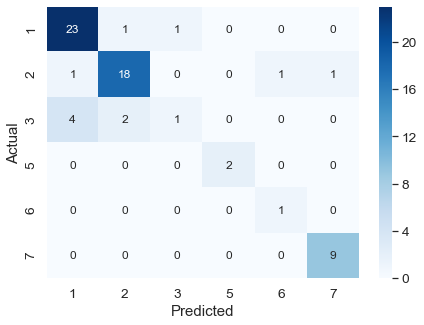

In [28]:
CM = pd.DataFrame(confusion_matrix(y_test, y_pred),
                  columns = np.unique(y_test),
                  index   = np.unique(y_test))
CM.index.name   = 'Actual'
CM.columns.name = 'Predicted'
plt.figure(figsize = (7, 5))
sns.set(font_scale=1.25)
sns.heatmap(CM, cmap = 'Blues',
            annot=True,
            annot_kws={'size':12})
plt.show()

Our best model wrongly predicted glass type 3 the most.

### Combining the top three models

In [29]:
# Generate 2D classification prediction
def Generate_2d(prediction):
    return (np.arange(y_train.max()+1) == prediction[...,None]).astype(int)

# fit all candidate models
fit_all = [model.fit(x_train, y_train) for model in models[3:]]

# generate 2d predictions for each model
y_pred_all = np.asarray([Generate_2d(model.predict(x_test)) for model in fit_all])

# Select the majority classes
y_pred_reduce = np.argmax(np.sum(y_pred_all, axis=0), axis=1)

In [30]:
accuracy_score(y_test, y_pred_reduce)

0.8461538461538461